In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 29 21:06:55 2018

@author: paulhuynh
"""

###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
%matplotlib inline
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np



In [7]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

###############################################################################
#   Functions to label encoding
###############################################################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE





In [8]:
###############################################################################
### Processing text into lists
###############################################################################

#set working Directory to where class corpus is saved.
# os.chdir('/Users/paulhuynh/Documents/School/2019 Winter/453 - Maren/2019 Winter - MSDS 453 - Class Corpus/')


#read in class corpus csv into python
data=pd.read_csv('2021_Summer_453_Sec55_Class_Corpus.csv')


data.head(10)

,Doc_ID,DSI_Title,Text
0,0,AK_Doc1_Biden-Administration-Moves.docx,Biden administration moves to safeguard DACA p...
1,1,AK_Doc2_President-Biden-the.docx,"President Biden, the Clock Is Ticking to Resci..."
2,2,Earnshaw1_Paris.docx,U.S. Rejoins Paris Climate Agreement\n\nPresid...
3,3,Earnshaw2_Antitrust.docx,Biden Is Assembling a Big Tech Antitrust All-S...
4,4,Earnshaw3_Nepa.docx,President Biden made clear his intention to re...
5,5,EHC_Doc1_Here-Are-Some.docx,TOPLINE A Russian criminal group is probably r...
6,6,EHC_Doc2_Microsoft-Says-Another.docx,Microsoft says another wave of Russian cyber-a...
7,7,HNN_Doc1_Housing-Crisis-Poses.docx,Housing crisis poses crucial test for Biden ad...
8,8,HNN_Doc2_America-Has-A.docx,"America Has a Housing Mess, and President Bide..."
9,9,JC_Doc1_IPOMarket.docx,Evolution Of The Biotech IPO Markets From Bust...


In [9]:
#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)
 

In [12]:
###############################################################################
### Sklearn TFIDF 
###############################################################################
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)



###############################################################################
### Explore TFIDF Values
###############################################################################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]



#can export matrix to csv and explore further if necessary

#matrix.head(10)

#average_TFIDF_DF['TFIDF'].value_counts()
#fig=average_TFIDF_DF['TFIDF'].plot().get_figure()

#fig.savefig("myplot.pdf")
#average_TFIDF_DF.boxplot(by column =['TFIDF'], grid = False)
#average_TFIDF_DF.plot.scatter()
#print(outlier_list.head)


In [13]:
###############################################################################
### Doc2Vec
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

###############################################################################
### Gensim Word2vec 
###############################################################################

#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec
model_w2v = Word2Vec(processed_text, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()


#the following section runs applies the k-means algorithm on the TFIDF matrix.



Top terms per cluster:
Cluster 0:
 housing
 housing policy
 white
 eviction
 moratorium
 policy
 mortgage
 households
 federal
 renters
Cluster 0 titles: HNN_Doc1_Housing-Crisis-Poses.docx, HNN_Doc2_America-Has-A.docx,Cluster 1:
 border
 immigration
 harris
 biden
 children
 democrats
 migrants
 bidens
 voters
 president
Cluster 1 titles: AK_Doc2_President-Biden-the.docx, NF_DOC1_Biden-Immigration-Policy-Problem.docx, NF_DOC2_Immigration-Advocates-Look-to-Biden.docx, PJB_Doc1_Harris Border Visit.docx, PJB_Doc2_What is Biden doing differently at border.docx,Cluster 2:
 russia
 ransomware
 attacks
 russian
 hackers
 attack
 cyber
 cybersecurity
 putin
 cyberattacks
Cluster 2 titles: EHC_Doc1_Here-Are-Some.docx, EHC_Doc2_Microsoft-Says-Another.docx, RMB_Doc1_They-Are-Hair.docx, RMB_Doc2_Once-Superpower-Summits.docx, RMB_Doc3_DOE-Asks-Congress.docx,Cluster 3:
 violence
 dealers
 crime
 firearms
 biden
 federal
 death
 efforts
 cities
 justice
Cluster 3 titles: KES_Doc1_Joe-Biden-Gun-Contro

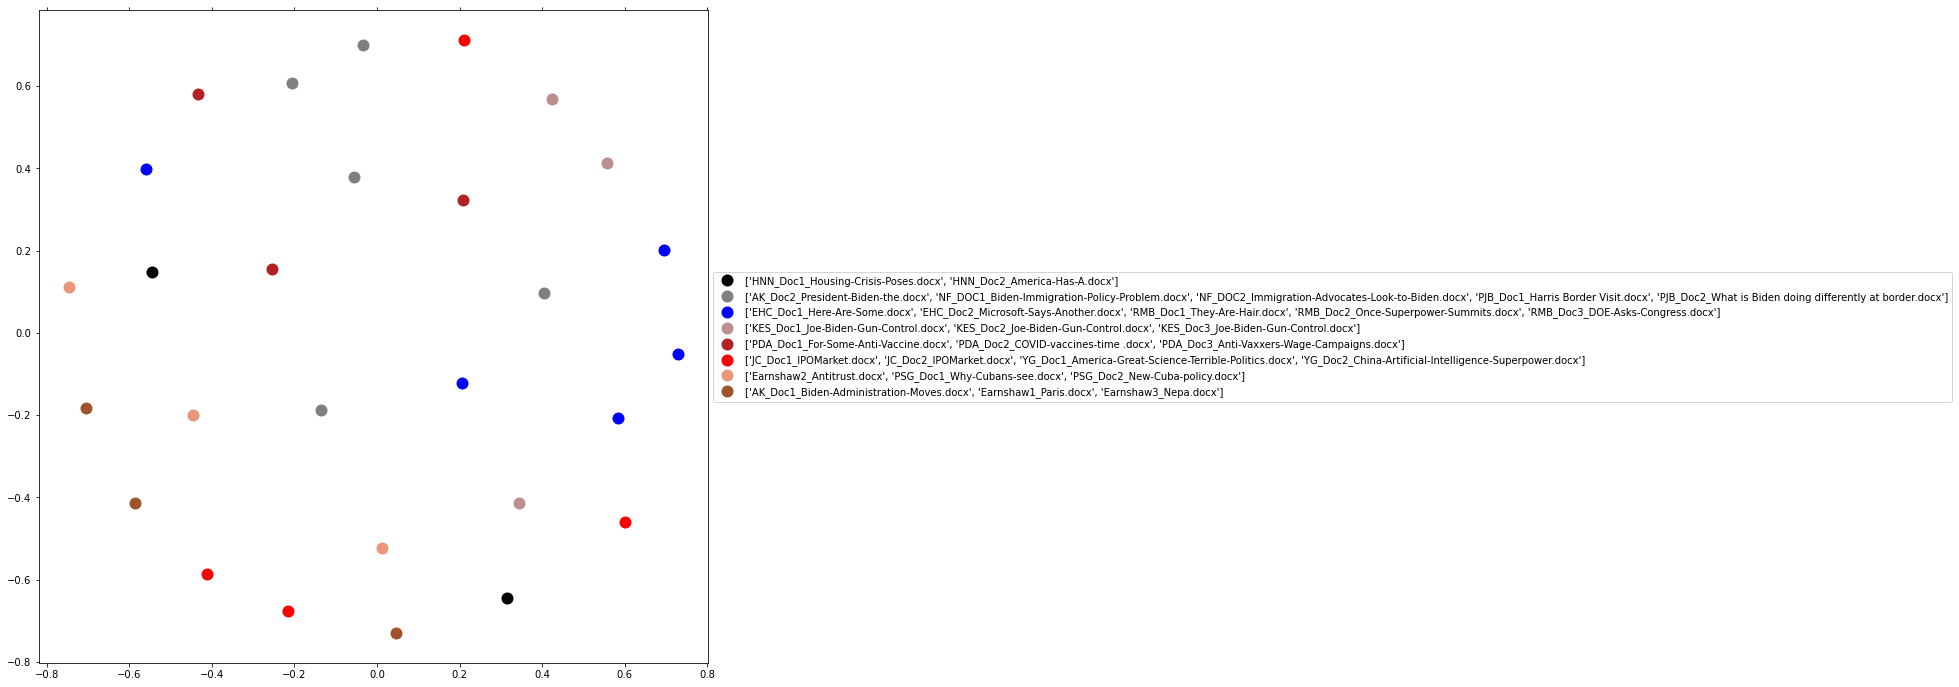

In [23]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles


###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

fig.savefig("myplot1.pdf",bbox_inches = 'tight')

#The following section of code is to run the k-means algorithm on the doc2vec outputs.
#note the differences in document clusters compared to the TFIDF matrix.


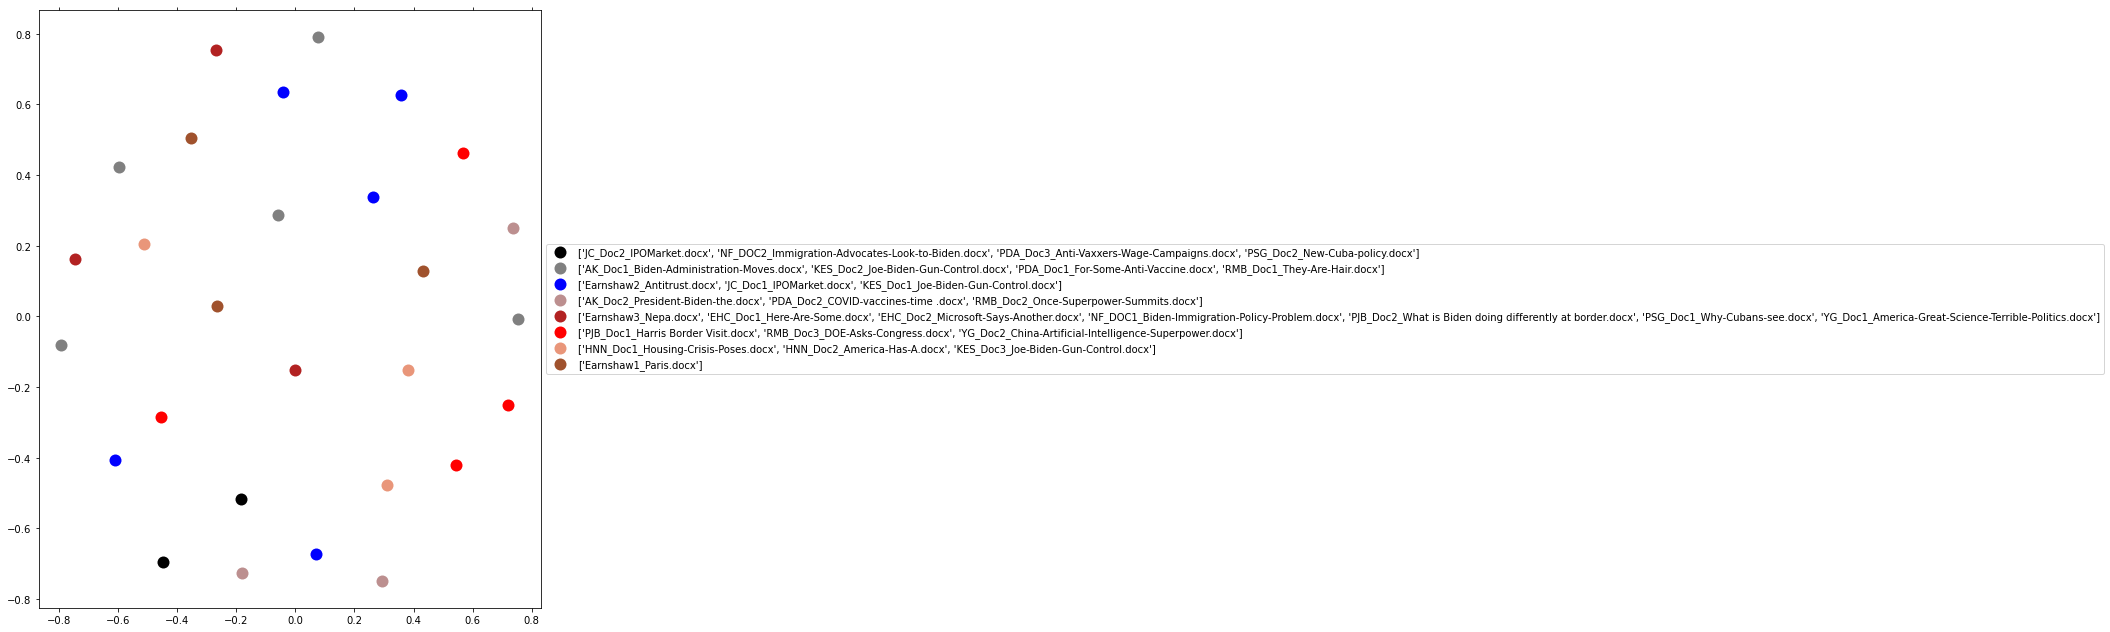

In [21]:
###############################################################################
### K Means Clustering Doc2Vec
###############################################################################
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list


###############################################################################
### Plotting Doc2vec
###############################################################################
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(9, 11)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point


#The following section is used to create a model to predict the clusters labels 
#based on the the TFIDF matrix and the doc2vec vectors.  Note the model performance 
#using the two different vectorization methods.
#fig2=ax.plot().get_figure()
fig.savefig("myplot2.pdf",bbox_inches = 'tight')


In [17]:
###############################################################################
### Classification using various RF Model
###############################################################################
model_RF=RandomForestClassifier()


#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=7)

#mean CV score
np.mean(cv_score)


#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=7)

#mean CV score
np.mean(cv_score)


#the following section is example code to create ECs within the corpus.  A dictionary
#will need to be created for every EC.  Each EC will need to be applied to the corpus.
#Below is an example of how the function works.


ValueError: n_splits=7 cannot be greater than the number of members in each class.

In [ ]:
###############################################################################
### EC clean up code 
###############################################################################
def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
            corpus= corpus.replace(value, key)
    return corpus


corpus='i like swiss.  i like cheddar.  i like provolone.'
cheese_dic={'cheese': ['swiss', 'cheddar', 'provolone']}

corpus_new=create_ec(cheese_dic, corpus)





In [ ]:
###############################################################################
###  LDA Code
###############################################################################

#LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

